In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 75

import sys
sys.path.append('../scripts')

from btsc_dataset import load_full_dataset, split_images_and_labels, resize_images
from utils import train_validation_test_split

import numpy as np

In [2]:
resized_data = resize_images(load_full_dataset(), size=32)
(images, labels) = split_images_and_labels(resized_data)
unique_labels = set(labels)

print('Images:', images.shape)
print('Labels:', labels.shape)
print('Total Unique Labels:', len(unique_labels))
labels

Images: (7095, 32, 32, 3)
Labels: (7095,)
Total Unique Labels: 62


array(['00000', '00000', '00000', ..., '00061', '00061', '00061'],
      dtype='<U5')

In [3]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

integer_labels= LabelEncoder().fit_transform(labels)
ont_hot_labels = to_categorical(integer_labels)

X = images
y = ont_hot_labels

X_train, X_valid, X_test, \
y_train, y_valid, y_test = train_validation_test_split(X, y, random_state=42)

print('X:', X.shape)
print('y:', y.shape)
print()
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print()
print('X_valid:', X_valid.shape)
print('y_valid:', y_valid.shape)
print()
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

Using TensorFlow backend.


X: (7095, 32, 32, 3)
y: (7095, 62)

X_train: (4257, 32, 32, 3)
y_train: (4257, 62)

X_valid: (1419, 32, 32, 3)
y_valid: (1419, 62)

X_test: (1419, 32, 32, 3)
y_test: (1419, 62)


In [4]:
from keras.models import *
from keras.layers import *

model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape=X[0].shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# TODO: Early Stopping
#nTODO: Data Augmentation
# TODO: VGG16, ...
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(len(unique_labels), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [5]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=50, epochs=10, verbose=1)

Train on 4257 samples, validate on 1419 samples
Epoch 1/10
4257/4257 [==============================] - 4s 834us/step - loss: 2.5831 - acc: 0.4198 - val_loss: 1.5007 - val_acc: 0.6568
Epoch 2/10
4257/4257 [==============================] - 2s 584us/step - loss: 1.0839 - acc: 0.7667 - val_loss: 0.7591 - val_acc: 0.8288
Epoch 3/10
4257/4257 [==============================] - 2s 585us/step - loss: 0.5809 - acc: 0.8729 - val_loss: 0.4892 - val_acc: 0.8887
Epoch 4/10
4257/4257 [==============================] - 3s 599us/step - loss: 0.3537 - acc: 0.9237 - val_loss: 0.3748 - val_acc: 0.9049
Epoch 5/10
4257/4257 [==============================] - 3s 589us/step - loss: 0.2319 - acc: 0.9464 - val_loss: 0.2964 - val_acc: 0.9352
Epoch 6/10
4257/4257 [==============================] - 3s 589us/step - loss: 0.1526 - acc: 0.9690 - val_loss: 0.2335 - val_acc: 0.9514
Epoch 7/10
4257/4257 [==============================] - 3s 592us/step - loss: 0.1037 - acc: 0.9786 - val_loss: 0.2238 - val_acc: 0.9479


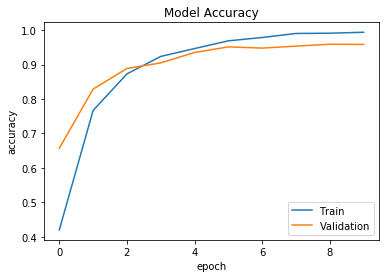

In [6]:
# Plot training & validation accuracies per epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

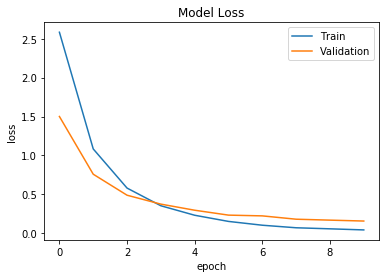

In [7]:
# Plot training & validation losses per epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [8]:
loss, acc = model.evaluate(X_test, y_test, verbose=1)

print('Test Results:')
print('  Loss     =', loss)
print('  Accuracy =', acc)

1419/1419 [==============================] - 0s 193us/step
Test Results:
  Loss     = 0.15818039440747464
  Accuracy = 0.9598308670176344
